# Import libraries

In [8]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow.contrib import learn
from tqdm import trange
from time import time
from Autoencoder.utils import *

# AutoEncoder

In [2]:
class AutoEncoder(object):

  def __init__(self,
               sess,
               inputs,
               targets=None,
               b1=0.5,
               lr=1.,
               code_size=16,
               batch_size=256,
               n_epoch=200,
               cost_function='bce',
               name='autoencoder',
               optimizer='adadelta'):
    self.sess = sess  #tensorflow session
    self.b1 = b1  #beta1 for AdadeltaOptimizer
    self.lr = lr  #learning rate
    self.n_epoch = n_epoch  #number of epoch
    self.batch_size = batch_size
    self.inputs = inputs
    self.code_size = code_size  #embedding size
    self.load_dataset()
    if targets is not None:
      self.targets = targets  #for autoencoder, targets is the same to input
      self.gen_noisy_data()
    else:
      self.targets = inputs
    self.cost_function = cost_function
    self.optimizer = optimizer
    self.log = {'train_loss': [], 'valid_loss': []}

    self.name = name

    self.build_model()

  def build_model(self):
    code_size = self.code_size
    with tf.variable_scope(self.name) as scope:
      self.enc1 = tf.layers.dense(
          inputs=self.inputs,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='enc')
      self.enc2 = tf.layers.dense(
          inputs=self.enc1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='enc2')
      self.enc3 = tf.layers.dense(
          inputs=self.enc2,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='enc3')
      self.code = tf.layers.dense(
          inputs=self.enc3, units=code_size, activation=tf.nn.relu, name='code')

      self.dec1 = tf.layers.dense(
          inputs=self.code,
          units=code_size * 4,
          activation=tf.nn.relu,
          name='dec')
      self.dec2 = tf.layers.dense(
          inputs=self.dec1,
          units=code_size * 8,
          activation=tf.nn.relu,
          name='dec2')
      self.dec3 = tf.layers.dense(
          inputs=self.dec2,
          units=code_size * 16,
          activation=tf.nn.relu,
          name='dec3')
      self.recon_logits = tf.layers.dense(
          inputs=self.dec3, units=28 * 28, name='recon_logits')
      self.jacobian_op = self.jacobian(self.code, self.inputs)
      if self.cost_function == 'mse':
        self.recon = self.recon_logits
        self.cost = tf.reduce_mean(tf.pow(self.targets - self.recon_logits, 2))
      elif self.cost_function == 'bce':
        self.recon = tf.nn.sigmoid(self.recon_logits)
        self.cost = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.targets, logits=self.recon_logits))

      else:
        raise NotImplementedError

  def train(self):
    if self.optimizer == 'adadelta':
      self.optim = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
    elif self.optimizer == 'adam':
      self.optim = tf.train.AdamOptimizer(
          self.lr, beta1=self.b1).minimize(self.cost)
    elif self.optimizer == 'rmsprop':
      self.optim = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
    else:
      raise NotImplementedError
    init = tf.global_variables_initializer()
    self.sess.run(init)

    X = self.inputs
    t0 = time()
    if self.targets is not self.inputs:
      print('Denoising autoencoder')
      Y = self.targets
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX, self.trX_noisy)
        for batch, noisy_batch in iter_data(
            self.trX, self.trX_noisy, size=self.batch_size):
          self.optim.run(
              session=self.sess, feed_dict={X: noisy_batch,
                                            Y: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]
        valid_noisy_batch = self.vaX_noisy[idxs]

        self.log['train_loss'].append(
            self.cost.eval(
                session=self.sess, feed_dict={X: noisy_batch,
                                              Y: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(
                session=self.sess,
                feed_dict={X: valid_noisy_batch,
                           Y: valid_batch}))
      print("final loss %g, total cost time: %.2fs" % (self.cost.eval(
          session=self.sess, feed_dict={X: self.teX_noisy,
                                        Y: self.teX}), time() - t0))

    else:
      print('Audoencoder')
      for epoch in trange(self.n_epoch):
        t = time()
        shuffle(self.trX)
        for batch in iter_data(self.trX, size=self.batch_size):
          self.optim.run(session=self.sess, feed_dict={X: batch})

        idxs = np.random.randint(
            low=0, high=len(self.vaX), size=self.batch_size)
        valid_batch = self.vaX[idxs]

        self.log['train_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: batch}))
        self.log['valid_loss'].append(
            self.cost.eval(session=self.sess, feed_dict={X: valid_batch}))
      print("final loss %g, total cost time: %.2fs" %
            (self.cost.eval(session=self.sess, feed_dict={X: self.teX}),
             time() - t0))

  def load_dataset(self):
    mnist = learn.datasets.load_dataset("mnist")
    self.trX = mnist.train.images  # Returns np.array
    self.vaX = mnist.validation.images  # Returns np.array
    self.teX = mnist.test.images

  def gen_noisy_data(self):
    # Noise scale
    noise_factor = 0.4
    trX_noisy = self.trX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.trX.shape)
    vaX_noisy = self.vaX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.vaX.shape)
    teX_noisy = self.teX + noise_factor * np.random.normal(
        loc=0., scale=1.0, size=self.teX.shape)

    # Range of our dataset is [0,1]
    self.trX_noisy = np.clip(trX_noisy, 0., 1.)
    self.vaX_noisy = np.clip(vaX_noisy, 0., 1.)
    self.teX_noisy = np.clip(teX_noisy, 0., 1.)

  def encode(self, inputs):

    return self.code.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def reconstruct(self, inputs):
    return self.recon.eval(session=self.sess, feed_dict={self.inputs: inputs})

  def jacobian(self, y, x):
    # For function f: mapping from single column x to multiple values ys
    # Note: tf.gradients returns sum(dy/dx)
    # for each x in xs, so we need to compute each y seperatedly.
    jacobian_flat = tf.concat(
        [tf.gradients(y_i, x)[0] for y_i in tf.unstack(y, axis=1)], axis=0)
    return jacobian_flat

  def get_jaco_matrix(self, xbatch):
    jaco_matrix = []
    for x in xbatch:
      jaco_matrix.append(
          self.jacobian_op.eval(
              session=self.sess, feed_dict={self.inputs: x.reshape(1, -1)})
          .reshape(1, self.code_size, 28 * 28))
    return np.concatenate(jaco_matrix)

In [3]:
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 28 * 28])
autoencoder = AutoEncoder(sess=sess, inputs=X, optimizer='adadelta', lr=1)
autoencoder.train()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


  0%|          | 0/200 [00:00<?, ?it/s]

Audoencoder


100%|██████████| 200/200 [14:37<00:00,  4.39s/it]


final loss 0.100928, total cost time: 877.92s


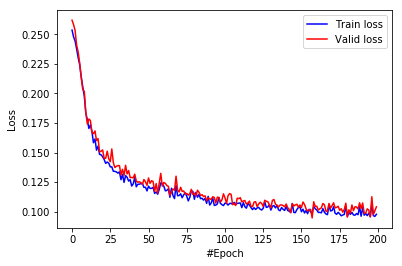

In [5]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

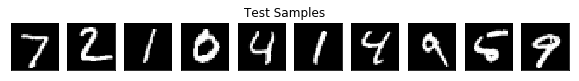

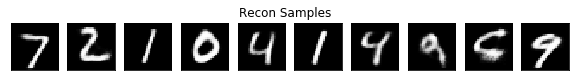

In [6]:
n = 10

orig_imgs = autoencoder.teX[:n].reshape(-1, 28, 28)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, 28 * 28)).reshape(-1, 28, 28)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

(1, 16, 784)
(16,)


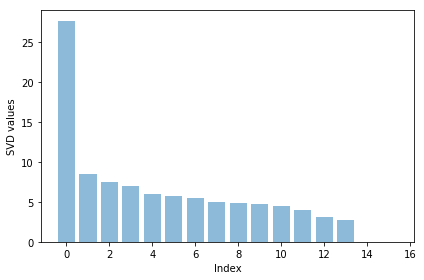

(16, 784)


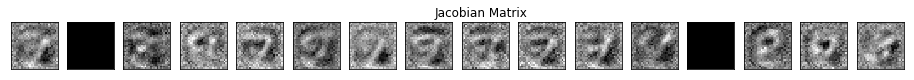

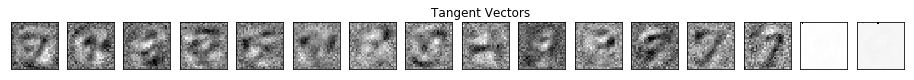

In [7]:
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
print(jaco_matrix.shape)
V = tangent_vecs(jaco_matrix[0])
print(V.shape)
plot_imgs(jaco_matrix.reshape(-1, 28, 28), n=16, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, 28, 28), n=16, title='Tangent Vectors')

In [9]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder(tf.float32, shape=[None, 28 * 28])
Y = tf.placeholder(tf.float32, shape=[None, 28 * 28])

# In our AutoEncoder class,
# it will automatically change to denoising autoencoder if "targets" is given.
autoencoder = AutoEncoder(
    sess=sess, inputs=X, targets=Y, optimizer='adadelta', lr=1)
# autoencoderModel = AutoEncoder(
#     sess=sess, inputs=X, optimizer='adam', niter=200, cost_function='mse')
autoencoder.train()

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


  0%|          | 0/200 [00:00<?, ?it/s]

Denoising autoencoder


100%|██████████| 200/200 [15:27<00:00,  4.64s/it]


final loss 0.116362, total cost time: 927.50s


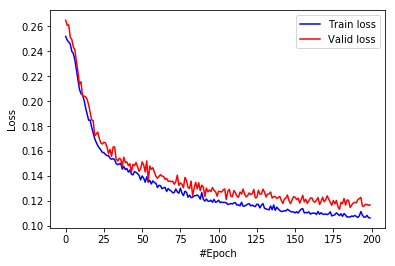

In [10]:
train_loss = autoencoder.log['train_loss']
valid_loss = autoencoder.log['valid_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.plot(range(len(valid_loss)), valid_loss, color='red', label='Valid loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

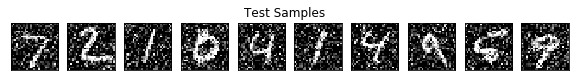

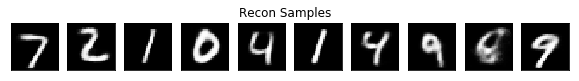

In [11]:
n = 10

orig_imgs = autoencoder.teX_noisy[:n].reshape(-1, 28, 28)
recon_imgs = autoencoder.reconstruct(
  orig_imgs.reshape(-1, 28 * 28)).reshape(-1, 28, 28)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Recon Samples')

(16,)


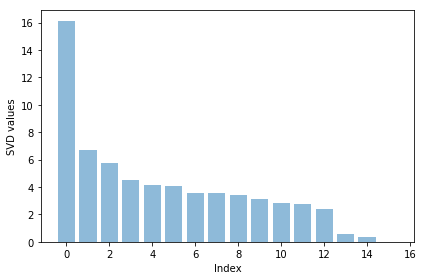

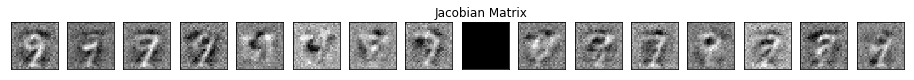

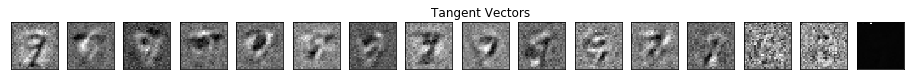

In [12]:
img = autoencoder.teX[:1]
jaco_matrix = autoencoder.get_jaco_matrix(img)
V = tangent_vecs(jaco_matrix[0])
plot_imgs(jaco_matrix.reshape(-1, 28, 28), n=16, title='Jacobian Matrix')
plot_imgs(V.reshape(-1, 28, 28), n=16, title='Tangent Vectors')

#reset the system path
sys.path.pop()

#reset tensorflow graph
tf.reset_default_graph()
sess.close()